# KRAS cis effect

This notebook creates a boxplot for the cis effect of KRAS hotspot mutations in 3 cancers. These 3 cancers were chosen because they have enough samples with KRAS hotspot mutations to do a t-test. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 

import cptac
import cptac.utils as u
import plot_utils as p
import cptac.pancan as pc

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import warnings
warnings.filterwarnings('ignore')

Functions:

format_df prepares a data frame with KRAS proteomics and KRAS mutation type from get_genotype_all_vars.

format_pval_annotation is used to add annotations to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [9]:
'''
Params
cancer_object: Object of the loaded cancer data set.
gene_in: Str of gene name. The mutation status of this gene will be returned in the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with cis proteomics and mutation status of a specific gene.
'''

def format_df(cancer_object, gene_in = 'KRAS', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in,"washu")
    mut_type['Mutation'].where(mut_type['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    mut_type['Mutation'].where(mut_type['Mutation'] != 'nonsynonymous SNV', 'Missense', inplace = True)
    
    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = gene_in, omics_source = "umich")
    prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)

    # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
    mut_type = mut_type[['Mutation']] 
    prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
    merged = prot_df.join(mut_type)

    # Keep only Wildtype and deletion
    compare = ['Wildtype_Tumor','Missense']
    get = merged['Mutation'].isin(compare)
    mut_wt = merged[get]

    return mut_wt


In [4]:
'''
Params
pval_symbol: String of the symbol to be used on the graph.
x1: Float. Start x position for the bracket.
x2: Float. End x position for the bracket.
line_start: Float. y position of bracket.
line_height: Float. Height of the bracket.

Returns an annotated plot.
'''

def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    return plt

# Step 1: Create data frames with KRAS missense mutations and Proteomics

Each cancer needs a df containing only tumor samples with either KRAS hotspot mutations or KRAS wildtype and KRAS proteomics.

First, load in cancer data sets from cptac.

In [5]:
l = pc.PancanLuad()
col = pc.PancanCoad()
en = pc.PancanUcec()

Next, use format_df to create the specific df for each cancer. Use wrap_ttest to test KRAS hotspot vs. wildtype. 

# Luad

In [14]:
gene = 'KRAS'
l_mut_wt = format_df(l, gene)
l_pval = u.wrap_ttest(l_mut_wt, 'Mutation', [gene+'_umich_proteomics'], return_all = True)
lp = l_pval.P_Value[0]
l_pval

,Comparison,P_Value
0,KRAS_umich_proteomics,0.000116


# Colon

In [15]:
c_mut_wt = format_df(col, gene)
c_pval = u.wrap_ttest(c_mut_wt, 'Mutation', ['KRAS_umich_proteomics'], return_all = True)
cp = c_pval.P_Value[0]
c_pval

,Comparison,P_Value
0,KRAS_umich_proteomics,0.023999


# Endometrial

In [16]:
e_mut_wt = format_df(en, gene)
e_pval = u.wrap_ttest(e_mut_wt, 'Mutation', ['KRAS_umich_proteomics'], return_all = True)
ep = e_pval.P_Value[0]
e_pval

,Comparison,P_Value
0,KRAS_umich_proteomics,0.014935


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

First create the Cancer column.

In [17]:
l_mut_wt = l_mut_wt.assign(cancer = 'Luad')
c_mut_wt = c_mut_wt.assign(cancer = 'Colon')
e_mut_wt = e_mut_wt.assign(cancer = 'Endometrial')

Next append the dfs.

In [18]:
df = l_mut_wt.append(c_mut_wt)
df2 = df.append(e_mut_wt)
df2

Name,KRAS_umich_proteomics,Mutation,cancer
Patient_ID,,,
11LU016,-0.538917,Wildtype_Tumor,Luad
11LU022,0.414393,Missense,Luad
11LU035,-0.065749,Wildtype_Tumor,Luad
C3L-00009,-0.134125,Wildtype_Tumor,Luad
C3L-00083,-0.021779,Wildtype_Tumor,Luad
...,...,...,...
C3N-01520,0.612965,Missense,Endometrial
C3N-01521,0.075389,Missense,Endometrial
C3N-01537,-0.112933,Wildtype_Tumor,Endometrial


# Step 3: Create the Pancancer Boxplot

p-values: 

Luad 0.00011603643707898646 

Colon 0.023999342468251958 

Endo 0.01493467424211918 



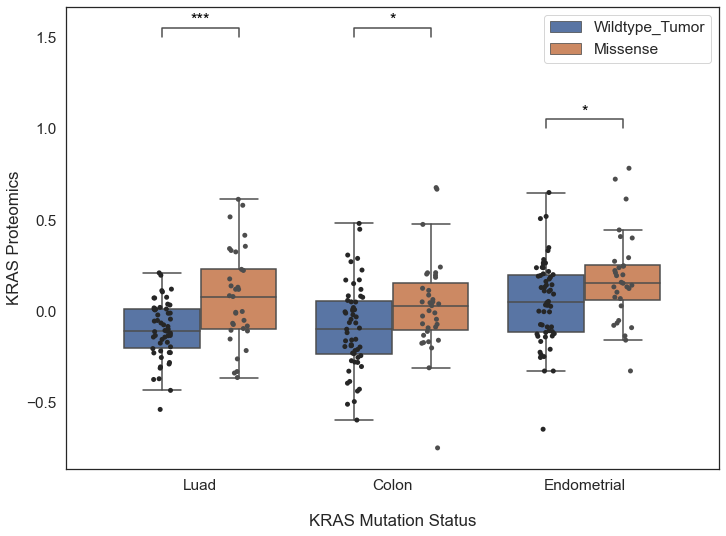

In [22]:
# cis plot
gene = 'KRAS'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(x='cancer', y=gene+"_umich_proteomics", data = df2, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Missense"], showfliers = False)    
#boxplot.set_title('Pancancer cis effect of PTEN CNV Deletions')
boxplot = sns.stripplot(x='cancer', y=gene+"_umich_proteomics", data = df2, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Missense"], dodge = True)
boxplot.set(xlabel = "\nKRAS Mutation Status", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

# Create significance symbols:
# * P < 0.015   ** P < 0.001   *** P < 0.0001 
cancer_pvals = {'Luad':lp, 'Colon':cp, 'Endo':ep}

# create pval annotations
symbols = {}
print('p-values: \n')
for cancer in cancer_pvals:
    val = str(cancer_pvals[cancer])
    if cancer_pvals[cancer]  < 0.001:
        symbols[cancer] = '***'
    elif cancer_pvals[cancer]  < 0.01:
        symbols[cancer] = '**'  
    elif cancer_pvals[cancer]  < 0.05:
        symbols[cancer] = '*'
    else:
        symbols[cancer] = 'ns'
    print(cancer, val, '\n')
        
format_pval_annotation(symbols['Luad'], -.2, 0.2, 1.5) 
format_pval_annotation(symbols['Colon'], .8, 1.2, 1.5)  
format_pval_annotation(symbols['Endo'], 1.8, 2.2, 1.0)

plt.show()
plt.clf()
plt.close()

In [ ]:
# Save figure
# fig = boxplot.get_figure()
# fig.savefig("KRAS_cis.png", dpi = 300)